# Working with misaligned data

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/307-working_with_misaligned.ipynb)

This notebook contains the examples of working with misaligned data.

**Table of contents**

* [Loading data](#chapter1)
* [Preparing data](#chapter2)
* [Forecasting](#chapter3)
* [Working with irregular data](#chapter4)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import LogTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform

In [3]:
HORIZON = 14

## 1. Loading data <a class="anchor" id="chapter1"></a>

Let's start by loading data with multiple segments.

In [4]:
df = pd.read_csv("data/example_dataset.csv", parse_dates=["timestamp"])
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


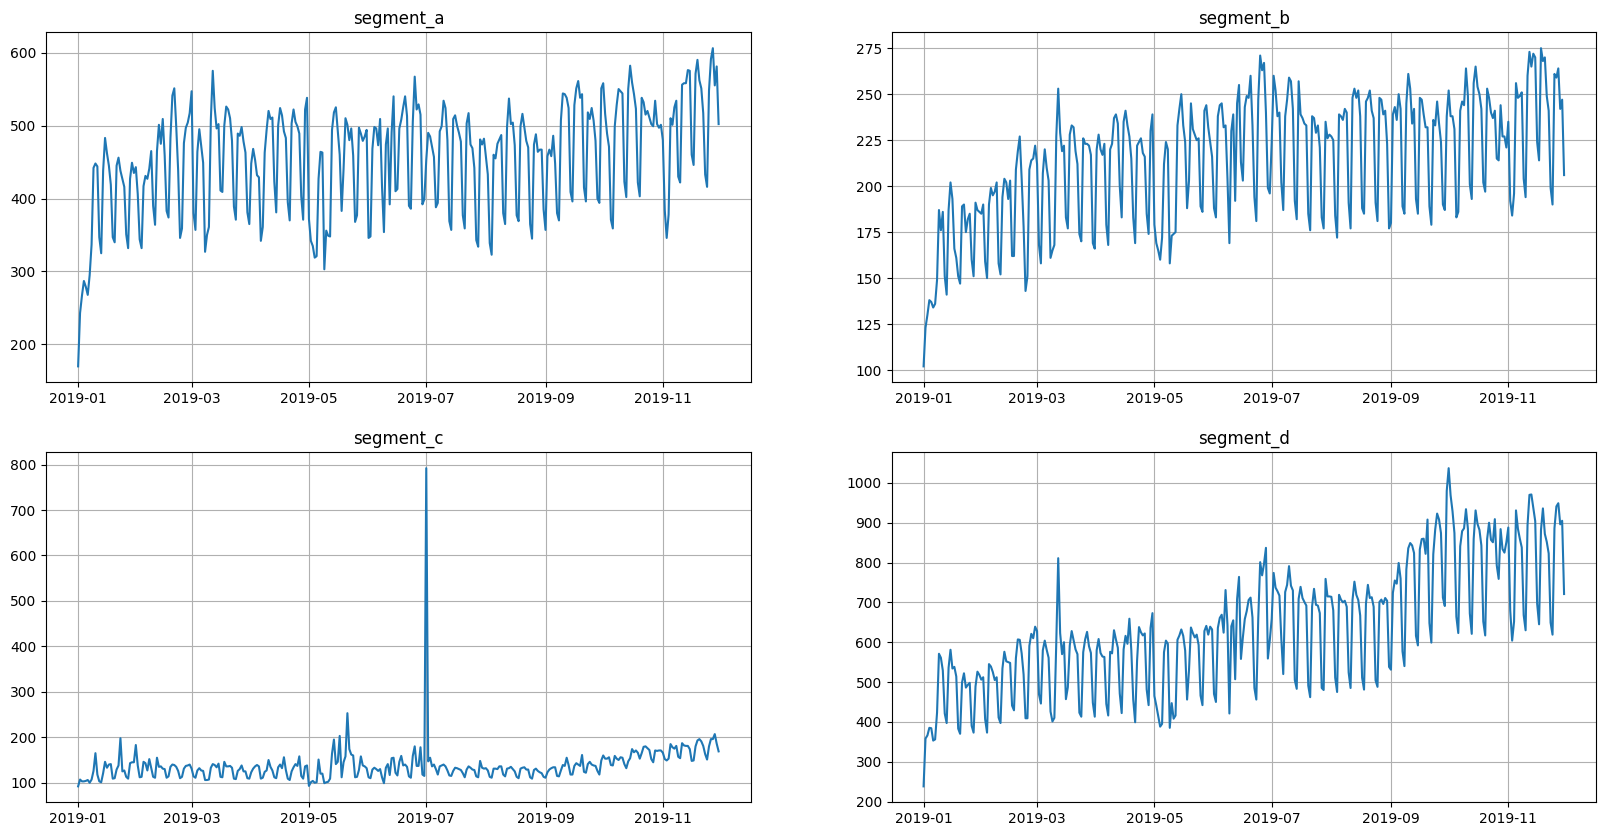

In [5]:
ts = TSDataset(df, freq="D")
ts.plot()

This data is aligned, but we need a misaligned data to make a demonstration. So, let's shift the segments.

In [6]:
df.loc[df["segment"] == "segment_b", "timestamp"] -= pd.Timedelta("365D")
df.loc[df["segment"] == "segment_c", "timestamp"] -= pd.Timedelta("730D")
df.loc[df["segment"] == "segment_d", "timestamp"] -= pd.Timedelta("1095D")

Now data is misaligned.

## 2. Preparing data <a class="anchor" id="chapter2"></a>

Our library by design works only with aligned data, so in order to support handling misaligned data we introduced the support of integer timestamp.

The idea is simple: if you have misaligned data you should create an integer timestamp that aligns times series with each other and then pass original timestamp as exogenous feature. In order to do all of this we added a special utilities.

The most simple way to prepare data is to use a special constructor for `TSDataset`: `TSDataset.create_from_misaligned`. 

Let's try it out

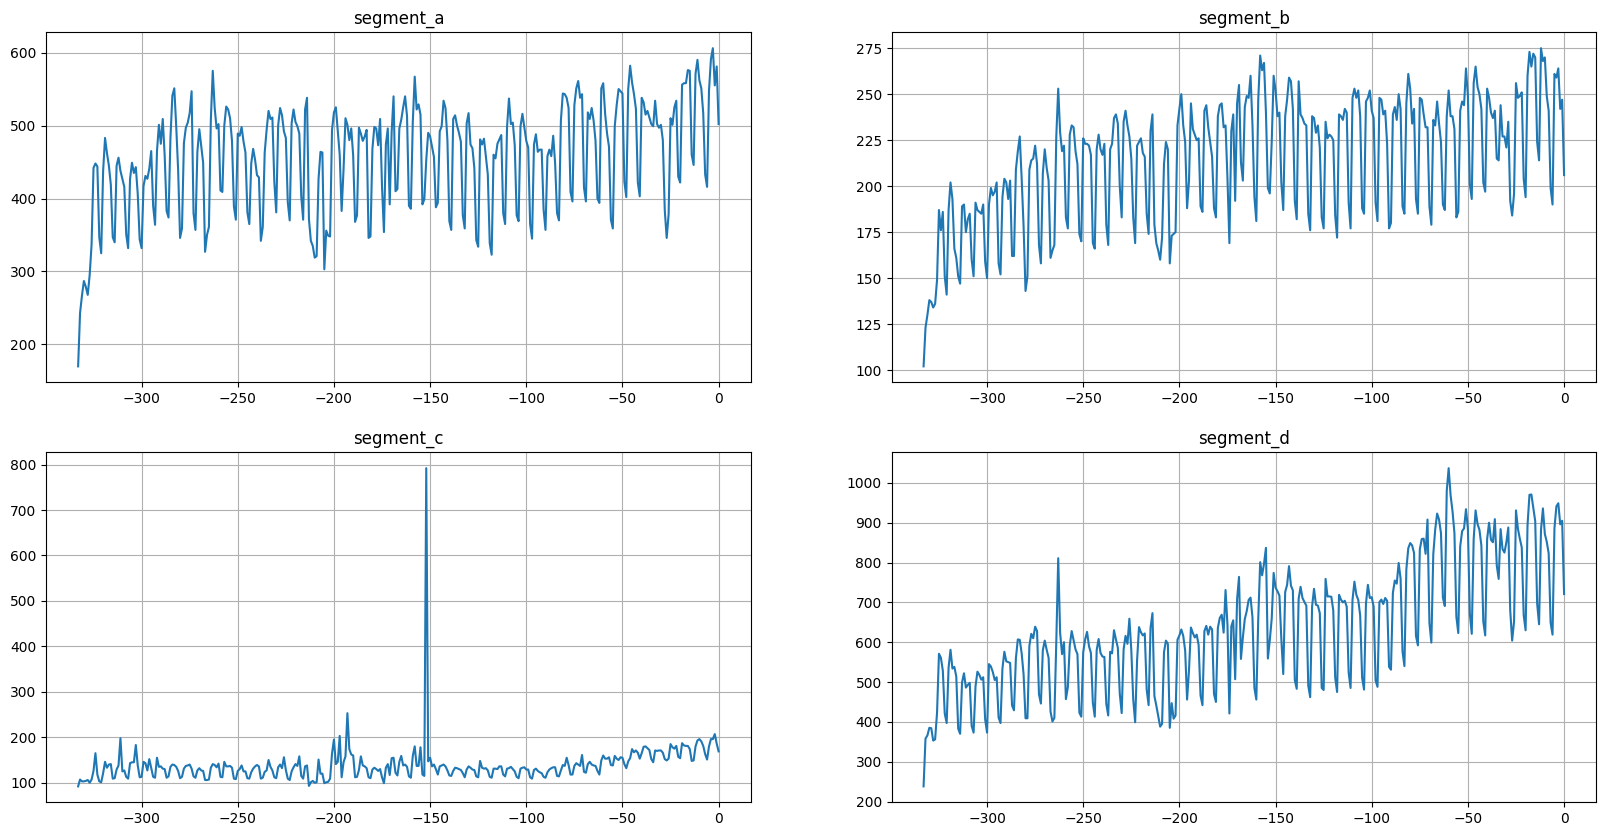

In [7]:
ts = TSDataset.create_from_misaligned(df=df, freq="D", future_steps=HORIZON)
ts.plot()

As we can see, now our time series are aligned by integer timestamp. There are few points to note:
- Parameter `df` is expected to be in a long format.
- The alignment is determined by the last timestamp for each segment. Last timestamp is taken without checking is `target` value missing or not.

Let's look at `ts` to check the presence of original timestamp:

In [8]:
ts.to_pandas()

segment            segment_a                 segment_b         \
feature   external_timestamp target external_timestamp target   
timestamp                                                       
-333              2019-01-01  170.0         2018-01-01  102.0   
-332              2019-01-02  243.0         2018-01-02  123.0   
-331              2019-01-03  267.0         2018-01-03  130.0   
-330              2019-01-04  287.0         2018-01-04  138.0   
-329              2019-01-05  279.0         2018-01-05  137.0   
...                      ...    ...                ...    ...   
-4                2019-11-26  591.0         2018-11-26  259.0   
-3                2019-11-27  606.0         2018-11-27  264.0   
-2                2019-11-28  555.0         2018-11-28  242.0   
-1                2019-11-29  581.0         2018-11-29  247.0   
 0                2019-11-30  502.0         2018-11-30  206.0   

segment            segment_c                 segment_d         
feature   external_timestamp target external_timestamp target  
timestamp                                                      
-333              2017-01-01   92.0         2016-01-02  238.0  
-332              2017-01-02  107.0         2016-01-03  358.0  
-331              2017-01-03  103.0         2016-01-04  366.0  
-330              2017-01-04  103.0         2016-01-05  385.0  
-329              2017-01-05  104.0         2016-01-06  384.0  
...                      ...    ...                ...    ...  
-4                2017-11-26  196.0         2016-11-26  941.0  
-3                2017-11-27  196.0         2016-11-27  949.0  
-2                2017-11-28  207.0         2016-11-28  896.0  
-1                2017-11-29  186.0         2016-11-29  905.0  
 0                2017-11-30  169.0         2016-11-30  721.0  

[334 rows x 8 columns]

The column with original timestamp is named `external_timestamp`, you could change the name by using a parameter named `original_timestamp_name` of `TSDataset.create_from_misaligned`. 

The feature `external_timestamp` is a regressor and it is extended into the future by `future_steps` steps.

In addition to using `TSDataset.create_from_misaligned` we could also use a more specific utilities and repeat the creation of `ts` from misaligned data.

First, we should infer the alignment used in our data. For this we should use `etna.datasets.infer_alignment`.

In [9]:
from etna.datasets import infer_alignment

alignment = infer_alignment(df)
alignment

{'segment_a': Timestamp('2019-11-30 00:00:00'),
 'segment_b': Timestamp('2018-11-30 00:00:00'),
 'segment_c': Timestamp('2017-11-30 00:00:00'),
 'segment_d': Timestamp('2016-11-30 00:00:00')}

As we can see, the last timestamp is taken for each segment. These timestamps will have the same integer timestamp after creation of `TSDataset`.

The next step is to create our integer timestamp by using `etna.datasets.apply_alignment`.

In [10]:
from etna.datasets import apply_alignment

df_aligned = apply_alignment(df=df, alignment=alignment, original_timestamp_name="external_timestamp")
df_aligned.head()

,external_timestamp,segment,target,timestamp
0,2019-01-01,segment_a,170,-333
1,2019-01-02,segment_a,243,-332
2,2019-01-03,segment_a,267,-331
3,2019-01-04,segment_a,287,-330
4,2019-01-05,segment_a,279,-329


As we can see, the original timestamp is saved under `external_timestamp` name. We don't really need it, because we want it to be extended into the future.

In [11]:
df_aligned = apply_alignment(df=df, alignment=alignment)
df_aligned.head()

,timestamp,segment,target
0,-333,segment_a,170
1,-332,segment_a,243
2,-331,segment_a,267
3,-330,segment_a,287
4,-329,segment_a,279


In order to make `external_timestamp` that extends into the future we are going to use `etna.datasets.make_timestamp_df_from_alignment`.

In [12]:
from etna.datasets import make_timestamp_df_from_alignment

start_idx = df_aligned["timestamp"].min()
end_idx = df_aligned["timestamp"].max() + HORIZON
df_exog = make_timestamp_df_from_alignment(alignment=alignment, start=start_idx, end=end_idx, freq="D")
df_exog.head()

,segment,timestamp,external_timestamp
0,segment_a,-333,2019-01-01
1,segment_a,-332,2019-01-02
2,segment_a,-331,2019-01-03
3,segment_a,-330,2019-01-04
4,segment_a,-329,2019-01-05


As you might already guessed parameters `start` and `end` determines on which set of integer timestamps the datetime timestamp will be generated.

The only thing that remains is to create `TSDataset`. We should set `freq=None`, because now we are using integer timestamp.

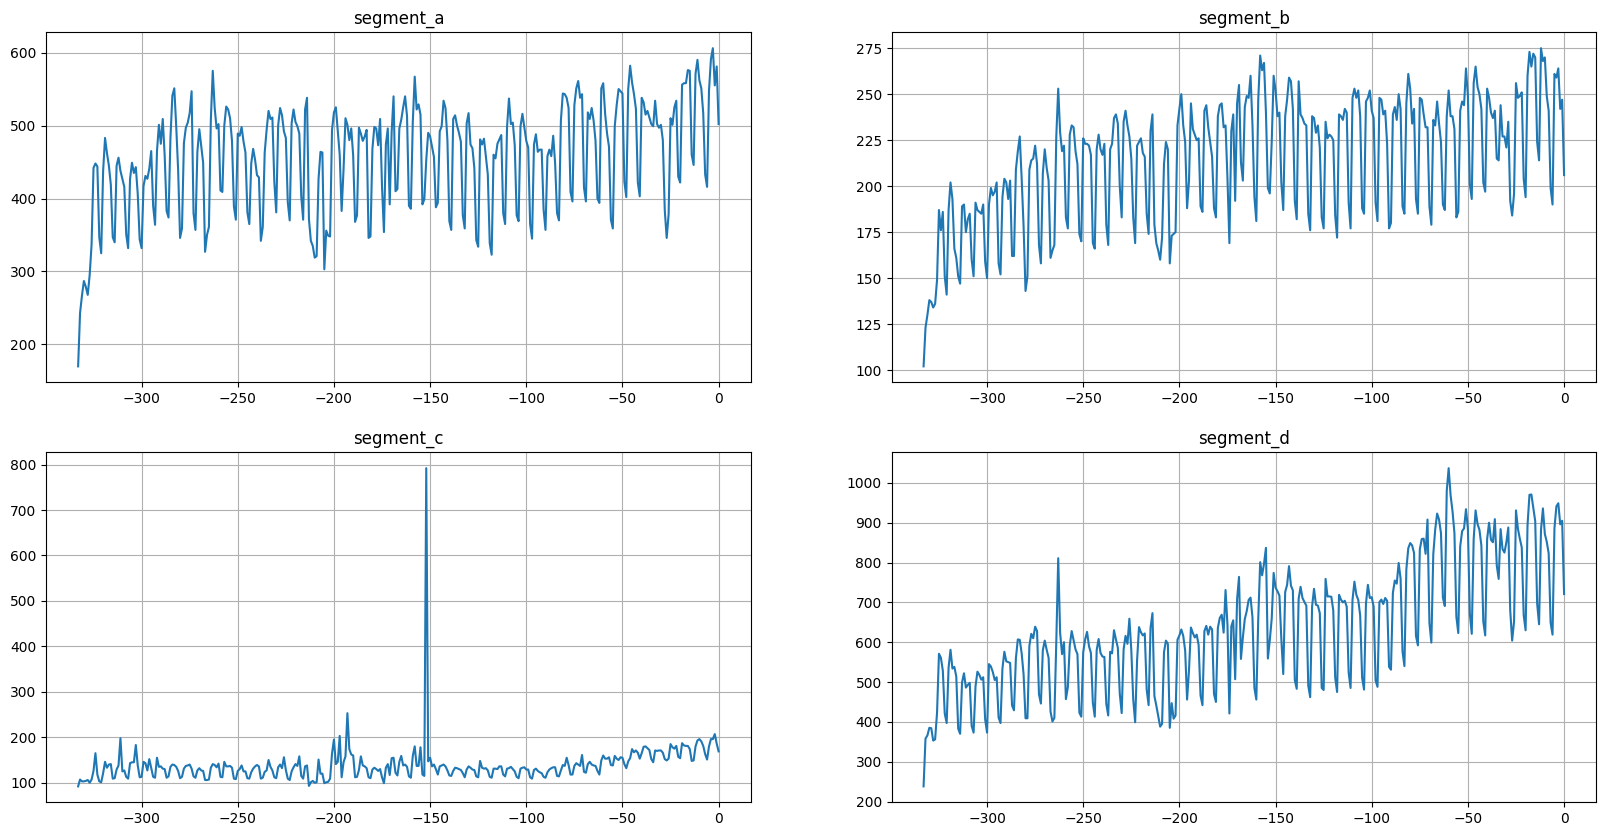

In [13]:
ts = TSDataset(df=df_aligned, df_exog=df_exog, freq=None, known_future="all")
ts.plot()

As we can see, the result is the same.

## 3. Forecasting <a class="anchor" id="chapter3"></a>

Now let's try to forecast created `ts`.

We are going to use `CatBoostMultiSegmentModel` and it could remain unchanged compared to working with aligned data,  because this model doesn't really use timestamp data, it uses only features generated by transforms.

However, it isn't true for all models, e.g. for `ProphetModel` we should also pass a parameter `timestamp_column` to work. 

In [14]:
model = CatBoostMultiSegmentModel()

As for transforms, we should prepare some of them to handle external timestamp by setting `in_column`.

In [15]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    in_column="external_timestamp",
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

And now we are ready to run a backtest.

In [16]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [17]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

Let's plot the results

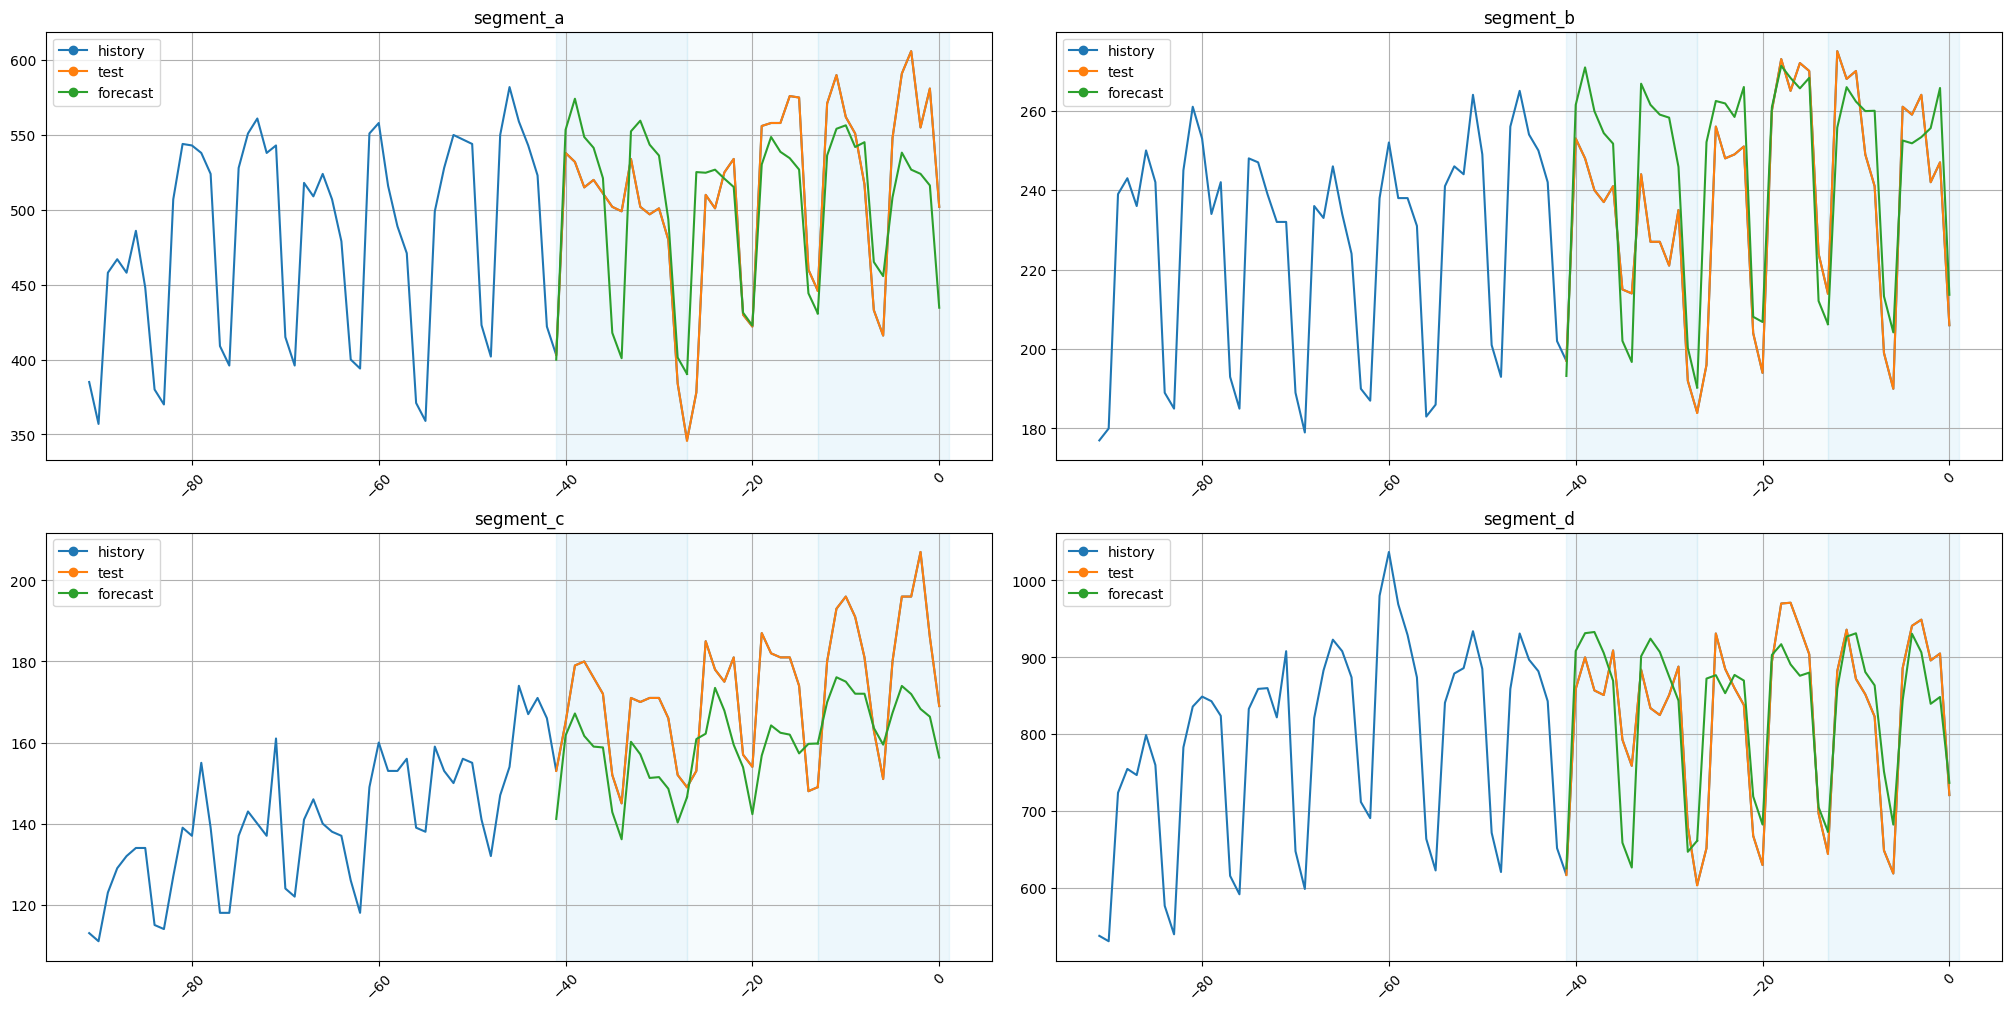

In [18]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

As we can see, the results are fine.

## 4. Working with irregular data <a class="anchor" id="chapter4"></a>

The explained mechanism could also potentially be used to work with irregular data where there is no specific frequency. However, not all transforms and models can work in such cases, and we haven't properly tested this behavior. So, you should be very careful if trying to do this.

That’s all for this notebook. More details you can find in our documentation!